### Libraries Used

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import textwrap
# adding entry into the specifications
# of the warnings filter.
warnings.filterwarnings('ignore', '.*do not.*', )
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm


#### Import Dataset

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/My Drive/WHO Heat Tool'
# print(os.listdir(path))

In [2]:
data = pd.read_excel("WHO_Heat_Tool_dataset.xlsx")

NameError: name 'pd' is not defined

In [ ]:
data

,record_id,date,country,province,district,sector,cell,respondent_role,hospital_name,distance_to_nearest_facility,...,rabies_choices___2,rabies_choices___3,rabies_choices___4,rabies_choices___5,rabies_choices___6,rabies_choices___7,rabies_choices___8,rabies_choices___9,rabies_comment,signal_function_performance_complete
0,1,2024-11-26,Rwanda,Kigali,Kicukiro,Masaka,Cyimo,1,2,CHUK,...,0,0,1,0,0,0,0,0,No comment,2
1,2,2024-11-27,RWANDA,Northern,Gakenke,Nemba,Mucaca,5,6,CHUK,...,0,0,0,0,0,0,0,0,No comment,2
2,3,2024-11-29,RWANDA,EAST,Bugesera,Nyamata,Nyamata ville,3,3,Rwanda Military hospital,...,0,0,0,0,0,0,0,0,No comment,2
3,5,2024-12-04,Rwanda,Southern,Huye,Ngoma,Butare,5,8,CHUB,...,0,0,1,0,0,0,0,0,No comment,2
4,6,2024-12-02,Rwanda,South,Kirehe,Kirehe,Gahama,1,4,Kibungo,...,0,0,0,0,0,0,0,0,No comment,2
5,7,2024-12-03,Rwanda,North,Burera,Butaro,Rusomo,3,5,CHUK/RMH,...,0,0,0,0,0,0,0,0,No comment,2
6,8,2024-12-09,Rwanda,South,Nyamasheke,Kanjongo,Kibogora,1,9,CHUB,...,0,0,0,0,0,0,0,0,No comment,2
7,9,2024-12-13,Rwanda,Western,RUBAVU,Gisenyi,Nengo,3,10,"RUHENGELI, CHUK, RMH",...,0,0,0,0,0,0,0,0,No comment,2
8,10,2024-12-16,RWANDA,Kigali City,NYARUGENGE,Nyarugenge,Kiyovu,7,1,King Faisal Hospital( not higher level but hel...,...,0,0,0,0,0,0,0,0,No comment,2
9,11,2024-12-12,Rwanda,Southern,Huye,Ngoma,Kabutare,5,7,CHUK/ King Faisal hospital,...,0,0,0,0,0,0,0,0,No comment,2


### Data Cleaning

In [ ]:
hospital_mapping = {
    1: "CHUK",
    2: "Masaka DH",
    3: "Nyamata DH",
    4: "Kirehe DH",
    5: "Butaro DH",
    6: "Nemba DH",
    7: "CHUB",
    8: "Kabutare DH",
    9: "Kibogora DH",
    10: "Gisenyi DH"
}

# Replace numeric values with hospital names
data["hospital_name_ae"] = data["hospital_name_ae"].map(hospital_mapping)
data["hospital_name_neo"] = data["hospital_name_neo"].map(hospital_mapping)
data["hospital_name_pedia"] = data["hospital_name_pedia"].map(hospital_mapping)
data["hospital_name"] = data["hospital_name"].map(hospital_mapping)

In [ ]:
import pandas as pd

def replace_values_in_columns(df, columns):
    """
    Replaces values in specified columns of a DataFrame:
    - Replace 1 with 0
    - Replace 2 with 50
    - Replace 3 with 100

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to apply the replacements.

    Returns:
        pd.DataFrame: The updated DataFrame with replaced values.
    """
    # Define the mapping dictionary
    value_mapping = {
        1: 0,
        2: 50,
        3: 100
    }

    # Apply the mapping to the specified columns
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(value_mapping)
        else:
            print(f"Warning: Column '{col}' does not exist in the DataFrame.")

    return df

import pandas as pd

def add_average_column(df, columns, new_column_name):
    """
    Adds a new column to the DataFrame containing the average of the specified columns.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to calculate the average from.
        new_column_name (str): Name of the new column to store the averages.

    Returns:
        pd.DataFrame: The DataFrame with the new column added.
    """
    # Calculate the average and add as a new column
    df[new_column_name] = df[columns].mean(axis=1)
    return df

def refined_stoplight_chart(df, hospital_name_col, hospital_level_col, category_cols, save_path=None):
    """
    Creates a refined stoplight chart with hospital names in the first row, levels in the second row,
    and category rows below. The left vertical line of the first column is removed.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        hospital_name_col (str): Column for hospital names.
        hospital_level_col (str): Column for hospital levels.
        category_cols (list): List of category columns.
        save_path (str): Optional path to save the chart.

    Returns:
        None: Displays or saves the chart.
    """
    def get_color(value):
        """Return circle color based on percentage thresholds."""
        if value > 95:
            return 'green'
        elif 75 <= value <= 95:
            return 'yellow'
        else:
            return 'red'

    def wrap_text(text, width):
        """Wrap text to a specified width."""
        return "\n".join(textwrap.wrap(text, width))

    # Figure setup
    n_hospitals = len(df)
    n_categories = len(category_cols)
    cell_height = 1.5
    cell_width = 2.5
    fig_width = cell_width * (n_hospitals + 1)
    fig_height = cell_height * (n_categories + 2)  # +2 for hospital name and level rows
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('off')

    # Draw grid (horizontal lines)
    for row in range(n_categories + 3):  # +3 for header rows and empty space
        ax.plot([0, fig_width], [row * cell_height, row * cell_height], color='black', linewidth=0.5)

    # Draw vertical grid lines except for the first column
    for col in range(1, n_hospitals + 2):  # +2 for labels and header
        ax.plot([col * cell_width, col * cell_width], [0, fig_height], color='black', linewidth=0.5)

    # Hospital names (First Row)
    for col_idx, hospital_name in enumerate(df[hospital_name_col]):
        x_pos = (col_idx + 1) * cell_width + cell_width / 2
        y_pos = fig_height - cell_height / 2
        wrapped_name = wrap_text(hospital_name, 12)  # Wrap hospital names to a width of 12 characters
        ax.text(x_pos, y_pos, wrapped_name, ha='center', va='center', fontsize=15, weight='bold')

    # Hospital levels (Second Row)
    for col_idx, hospital_level in enumerate(df[hospital_level_col]):
        x_pos = (col_idx + 1) * cell_width + cell_width / 2
        y_pos = fig_height - cell_height * 1.5
        wrapped_level = wrap_text(hospital_level, 12)  # Wrap hospital levels if necessary
        ax.text(x_pos, y_pos, wrapped_level, ha='center', va='center', fontsize=12, weight='bold', color='black')

    # Category labels (First Column, no vertical line)
    for row_idx, category in enumerate(category_cols):
        y_pos = fig_height - (row_idx + 3) * cell_height + cell_height / 2
        wrapped_category = wrap_text(category, 20)  # Wrap categories to a width of 20 characters
        ax.text(cell_width / 2, y_pos, wrapped_category, ha='right', va='center', fontsize=12)

    # Circles for data
    for row_idx, category in enumerate(category_cols):
        for col_idx in range(n_hospitals):
            value = df.iloc[col_idx][category]
            color = get_color(value)
            x_pos = (col_idx + 1) * cell_width + cell_width / 2
            y_pos = fig_height - (row_idx + 3) * cell_height + cell_height / 2
            ax.add_patch(plt.Circle((x_pos, y_pos), 0.4, color=color))

    # Adjust the left column (remove vertical line)
    ax.plot([0, cell_width], [0, fig_height], color='white', linewidth=2)

    # Save or display chart
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

###  1. A&E *Unit*

In [ ]:
ae_data = data.iloc[:,124:240]
hospital_levels = {
    "CHUK": "Referral/Teaching Hospital",
    "Masaka DH": "District Hospital",
    "Nyamata DH": "Level 2 Teaching Hospital",
    "Kirehe DH": "District Hospital",
    "Butaro DH": "Level 2 Teaching Hospital",
    "Nemba DH": "District Hospital",
    "CHUB": "Referral/Teaching Hospital",
    "Kabutare DH": "District Hospital",
    "Kibogora DH": "Level 2 Teaching Hospital",
    "Gisenyi DH": "District Hospital"
}

# Add the new column based on the mapping
ae_data['hospital_level'] = ae_data['hospital_name_ae'].map(hospital_levels)
data['hospital_level'] = data['hospital_name'].map(hospital_levels)

In [ ]:
infrasrtucture_ae = ['clean_running_water', 'electricity_source', 'designated_telephone',
       'isolation_room',  'easy_physical_access', 'waiting_area', 'triage_area', 'resuscitation_area','protective_equipment',
       'proportion_of_beds','crash_trolley','defibrillator_available', 'rapid_access', 'staff_area','access_to_storage',
       'toilet_facilities', 'handwashing_facilities', 'system', 'oxygen_in_emergency_unit']
ae_data = replace_values_in_columns(df = ae_data, columns = infrasrtucture_ae)
ae_data = add_average_column(df= ae_data, columns = infrasrtucture_ae, new_column_name = 'Infrastructures in A&E')
consulting_ae =['general_surgery_rate', 'orthopedics_rate', 'anaesthesia_rate','paediatrics_rate', 'mental_health_service_rate', 'plastic_and_reconstructive']

# consulting_ae =['general_surgery_rate', 'anaesthesia_rate','paediatrics_rate', 'mental_health_service_rate']
ae_data = replace_values_in_columns(df = ae_data, columns = consulting_ae)
ae_data = add_average_column(df= ae_data, columns = consulting_ae, new_column_name = 'Consulting Services in A&E')
ancillary_ae = ['social_work_services_rate', 'patient_transport_services','security_personnel',]
ae_data = replace_values_in_columns(df = ae_data, columns = ancillary_ae)
ae_data = add_average_column(df= ae_data, columns = ancillary_ae, new_column_name = 'Ancillary Services in A&E')

In [ ]:
care_test_ae = ['urine_dipstick',  'glucose_rate', 'arterial_blood_gas_rate',]
ae_data = replace_values_in_columns(df = ae_data, columns = care_test_ae)
ae_data = add_average_column(df= ae_data, columns = care_test_ae, new_column_name = 'Point of Care Testing available in the A&E unit')

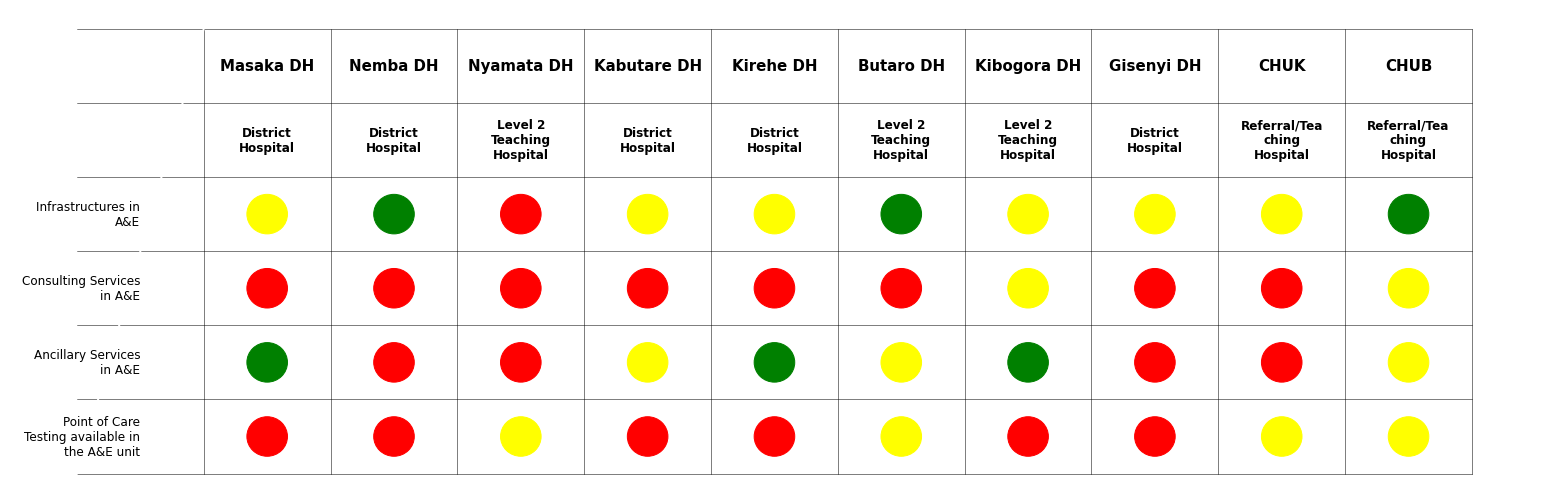

In [ ]:
refined_stoplight_chart(
    df=ae_data,
    hospital_name_col="hospital_name_ae",
    hospital_level_col="hospital_level",
    category_cols=["Infrastructures in A&E","Consulting Services in A&E",'Ancillary Services in A&E','Point of Care Testing available in the A&E unit']
)

### 2. Neonatal Emergence Unit

In [ ]:
neo_data = data.iloc[:,240:356]
neo_data['hospital_level'] = neo_data['hospital_name_neo'].map(hospital_levels)

In [ ]:
infrasrtucture_neo = ['clean_running_water_2', 'electricity_source_2', 'designated_telephone_2', 'isolation_room_2',  'easy_physical_access_2', 'waiting_area_2', 'triage_area_2', 'resuscitation_area_2','protective_equipment_2',
       'proportion_of_beds_2','crash_trolley_2','defibrillator_available_2', 'rapid_access_2', 'staff_area_2','access_to_storage_2','toilet_facilities_2', 'handwashing_facilities_2', 'system_2', 'oxygen_in_emergency_unit_2']
neo_data = replace_values_in_columns(df = neo_data, columns = infrasrtucture_neo)
neo_data = add_average_column(df= neo_data, columns = infrasrtucture_neo, new_column_name = 'Infrastructures in Neonatology Unit')

In [ ]:
consulting_neo =['general_surgery_rate_2', 'orthopedics_rate_2', 'anaesthesia_rate_2','paediatrics_rate_2', 'mental_health_service_rate_2', 'plastic_and_reconstructive_2']
neo_data = replace_values_in_columns(df = neo_data, columns = consulting_neo)
neo_data = add_average_column(df= neo_data, columns = consulting_neo, new_column_name = 'Consulting Services in Neonatologu Unit')

In [ ]:
ancillary_neo =['social_work_services_rate_2', 'patient_transport_services_2','security_personnel_2']
neo_data = replace_values_in_columns(df = neo_data, columns = ancillary_neo)
neo_data = add_average_column(df= neo_data, columns = ancillary_neo, new_column_name = 'Ancillary Services in Neonatologu Unit')

In [ ]:
care_test_neo = ['urine_dipstick_2',  'glucose_rate_2', 'arterial_blood_gas_rate_2',]
neo_data = replace_values_in_columns(df = neo_data, columns = care_test_neo)
neo_data = add_average_column(df= neo_data, columns = care_test_neo, new_column_name = 'Point of Care Testing available in the Neonatology unit')

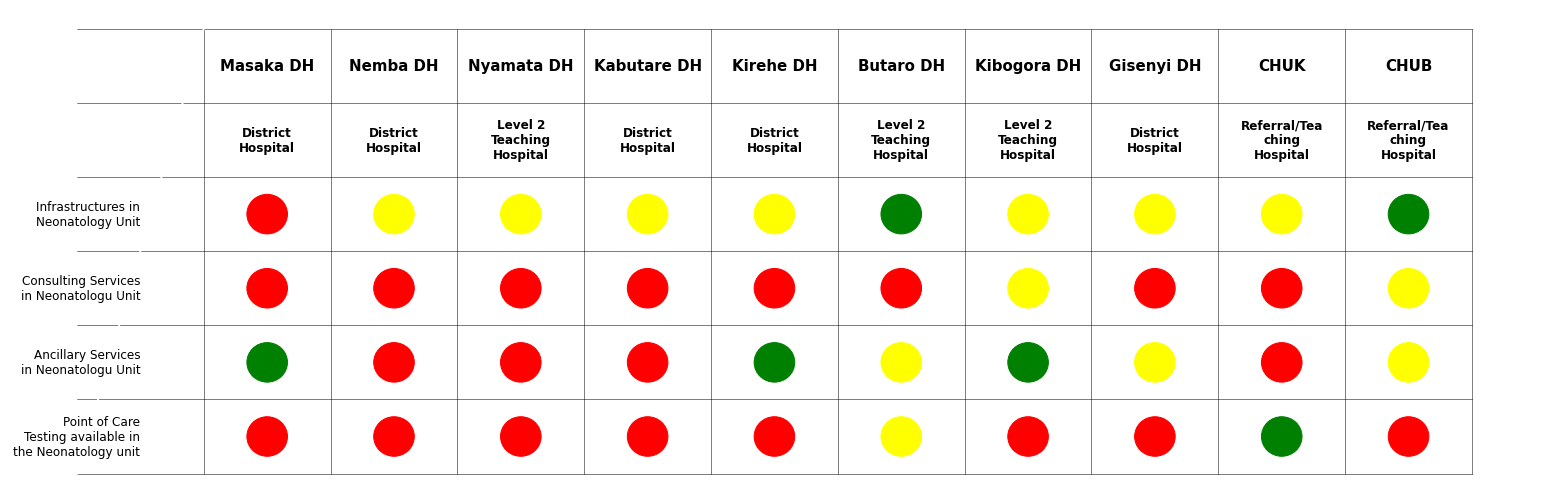

In [ ]:
# Generate refined stoplight chart
refined_stoplight_chart(
    df=neo_data,
    hospital_name_col="hospital_name_neo",
    hospital_level_col="hospital_level",
    category_cols=["Infrastructures in Neonatology Unit", 'Consulting Services in Neonatologu Unit','Ancillary Services in Neonatologu Unit','Point of Care Testing available in the Neonatology unit']
)

### 3. Pediatrics Emergence Unit

In [ ]:
pae_data = data.iloc[:,356:472]
pae_data['hospital_level'] = pae_data['hospital_name_pedia'].map(hospital_levels)

In [ ]:
infrasrtucture_pae = ['clean_running_water_3', 'electricity_source_3', 'designated_telephone_3', 'isolation_room_3',  'easy_physical_access_3', 'waiting_area_3', 'triage_area_3', 'resuscitation_area_3','protective_equipment_3',
       'proportion_of_beds_3','crash_trolley_3','defibrillator_available_3', 'rapid_access_3', 'staff_area_3','access_to_storage_3','toilet_facilities_3', 'handwashing_facilities_3', 'system_3', 'oxygen_in_emergency_unit_3']
pae_data = replace_values_in_columns(df = pae_data, columns = infrasrtucture_pae)
pae_data = add_average_column(df= pae_data, columns = infrasrtucture_pae, new_column_name = 'Infrastructures in Pediatric Unit')

In [ ]:
consulting_pae =['general_surgery_rate_3', 'orthopedics_rate_3', 'anaesthesia_rate_3','paediatrics_rate_3', 'mental_health_service_rate_3', 'plastic_and_reconstructive_3']
pae_data = replace_values_in_columns(df = pae_data, columns = consulting_pae)
pae_data = add_average_column(df= pae_data, columns = consulting_pae, new_column_name = 'Consulting Services in Pediatric Unit')

In [ ]:
ancillary_pae =['social_work_services_rate_3', 'patient_transport_services_3','security_personnel_3']
pae_data = replace_values_in_columns(df = pae_data, columns = ancillary_pae)
pae_data = add_average_column(df= pae_data, columns = ancillary_pae, new_column_name = 'Ancillary Services in Pediatric Unit')

In [ ]:
care_test_pae = ['urine_dipstick_3',  'glucose_rate_3', 'arterial_blood_gas_rate_3']
pae_data= replace_values_in_columns(df = pae_data, columns = care_test_pae)
pae_data = add_average_column(df= pae_data, columns = care_test_pae, new_column_name = 'Point of Care Testing available in the Pediatric unit')

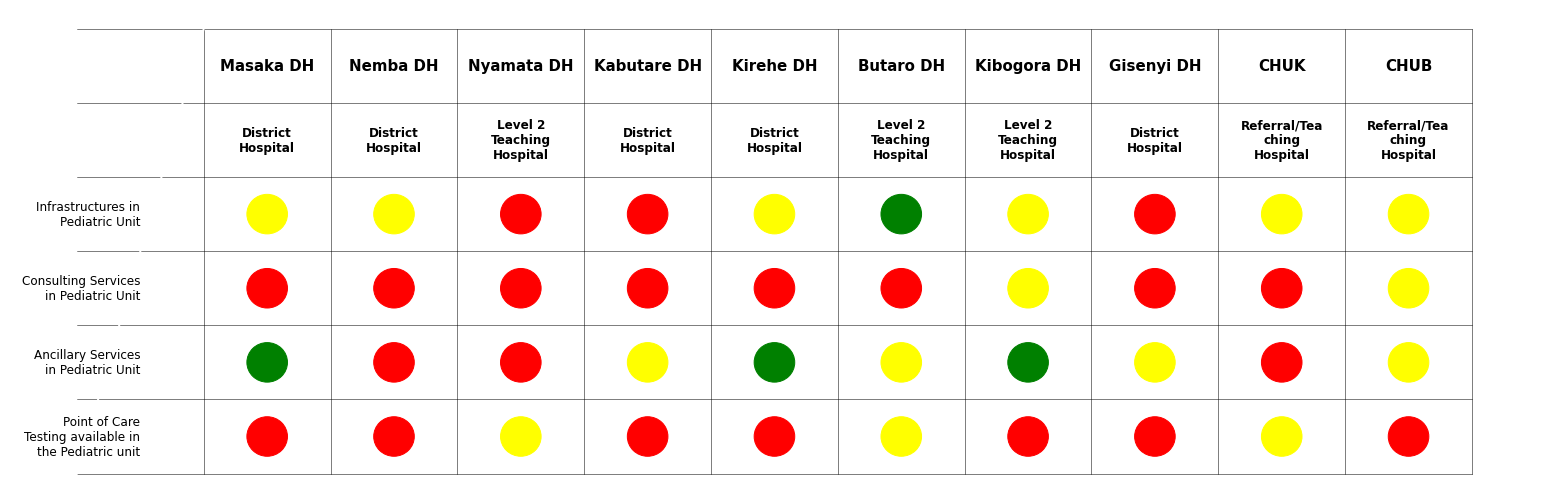

In [ ]:
# Generate refined stoplight chart
refined_stoplight_chart(
    df=pae_data,
    hospital_name_col="hospital_name_pedia",
    hospital_level_col="hospital_level",
    category_cols=["Infrastructures in Pediatric Unit",'Consulting Services in Pediatric Unit','Ancillary Services in Pediatric Unit','Point of Care Testing available in the Pediatric unit'])

#### All Three Units comparison

In [ ]:
df = ae_data[["hospital_name_ae", "hospital_level", "Infrastructures in A&E", "Consulting Services in A&E",'Ancillary Services in A&E', 'Point of Care Testing available in the A&E unit']]
df[["Infrastructures in Neonatology Unit",'Consulting Services in Neonatologu Unit','Ancillary Services in Neonatologu Unit','Point of Care Testing available in the Neonatology unit']] = neo_data[["Infrastructures in Neonatology Unit",'Consulting Services in Neonatologu Unit','Ancillary Services in Neonatologu Unit', 'Point of Care Testing available in the Neonatology unit']]
df[["Infrastructures in Pediatric Unit",'Consulting Services in Pediatric Unit','Ancillary Services in Pediatric Unit','Point of Care Testing available in the Pediatric unit']] = pae_data[["Infrastructures in Pediatric Unit",'Consulting Services in Pediatric Unit','Ancillary Services in Pediatric Unit','Point of Care Testing available in the Pediatric unit']]

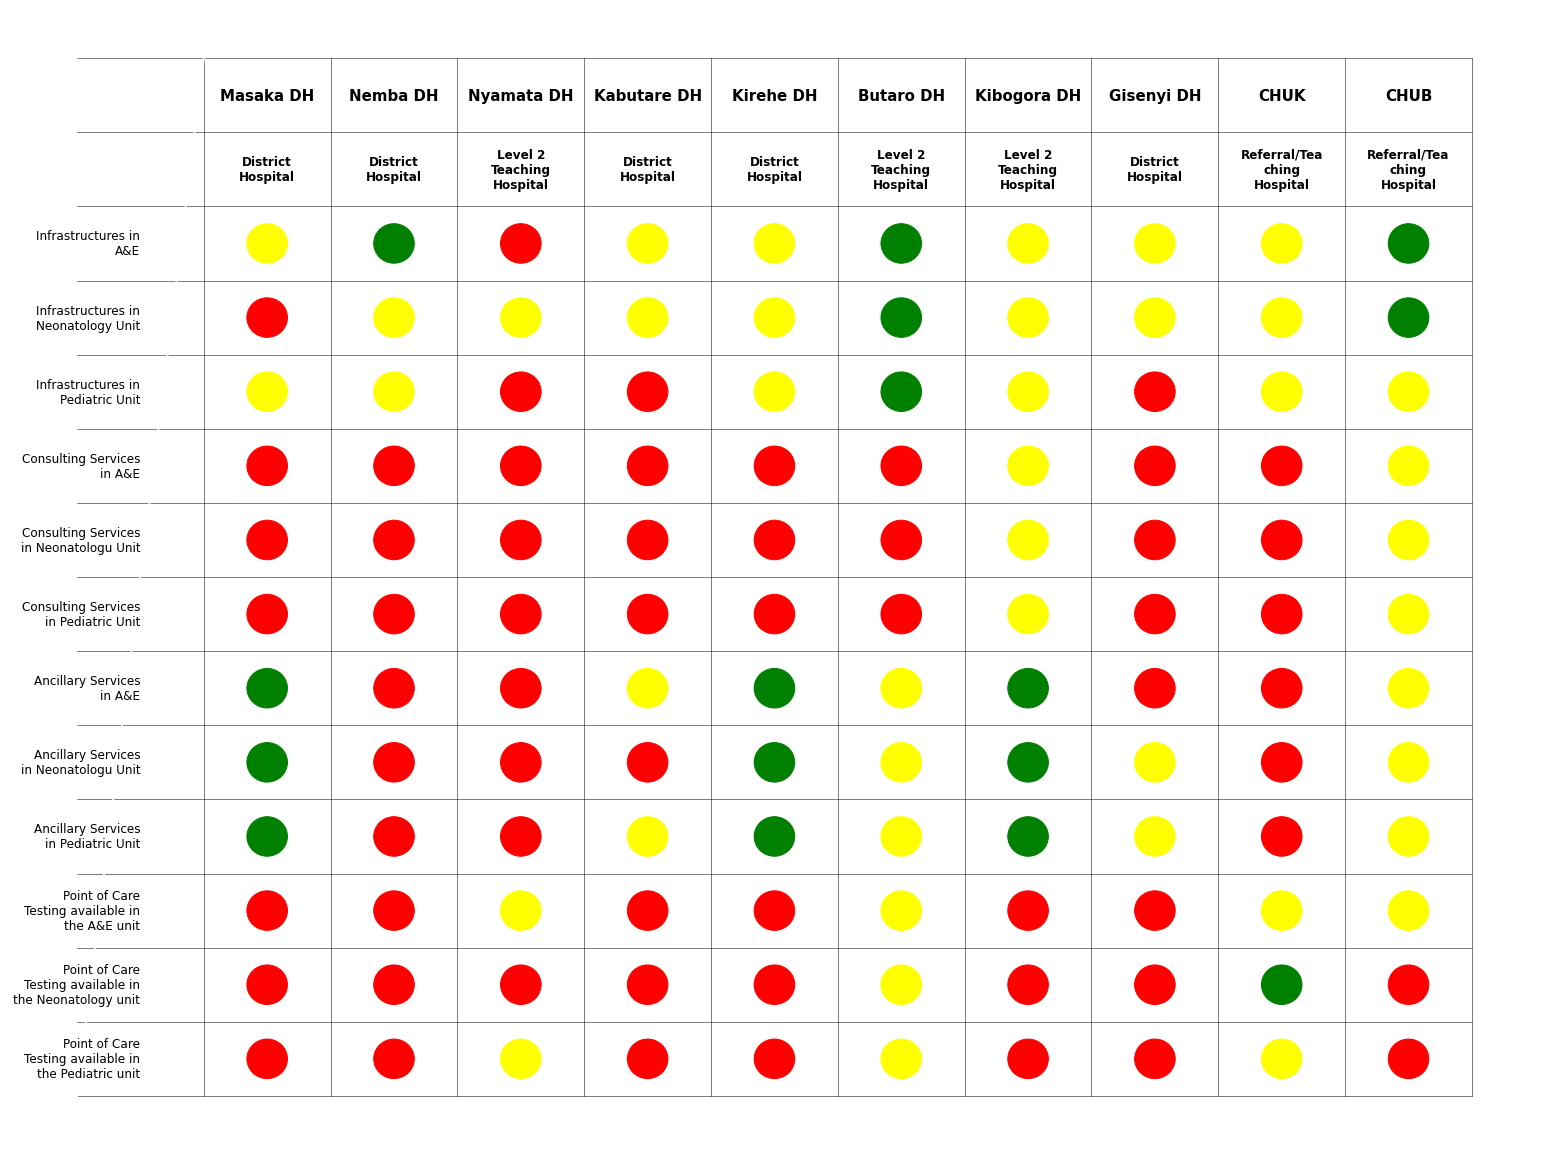

In [ ]:
refined_stoplight_chart(
    df= df ,
    hospital_name_col="hospital_name_ae",
    hospital_level_col="hospital_level",
    category_cols=["Infrastructures in A&E","Infrastructures in Neonatology Unit","Infrastructures in Pediatric Unit","Consulting Services in A&E",'Consulting Services in Neonatologu Unit', 'Consulting Services in Pediatric Unit','Ancillary Services in A&E','Ancillary Services in Neonatologu Unit','Ancillary Services in Pediatric Unit', 'Point of Care Testing available in the A&E unit', 'Point of Care Testing available in the Neonatology unit', 'Point of Care Testing available in the Pediatric unit'],
    save_path="Stop_light_chart_per_unit.png")

In [ ]:
data.iloc[:,100:125].columns

Index(['blood_smear_test_choices___9', 'reporting_critical_lab',
       'reporting_critical_lab_choices___1',
       'reporting_critical_lab_choices___2',
       'reporting_critical_lab_choices___3',
       'reporting_critical_lab_choices___4',
       'reporting_critical_lab_choices___5',
       'reporting_critical_lab_choices___6',
       'reporting_critical_lab_choices___7',
       'reporting_critical_lab_choices___8',
       'reporting_critical_lab_choices___9', 'full_blood_count_comment',
       'coagulation_profile_pt_ptt_comment', 'electrolytes_comments',
       'bun_and_creatinine_comment', 'urine_microscopy_comment',
       'cross_matching_for_blood_comment', 'system_for_reporting_comment',
       'blood_smear_test_comment', 'reporting_critical_lab_comment',
       'unit_is_assessed___1', 'unit_is_assessed___2', 'unit_is_assessed___3',
       'facility_characteristics_complete', 'assessment_date_ae'],
      dtype='object')

In [ ]:
diagnostic = ['full_blood_rate', 'coagulation_profile_pt_ptt','electrolytes', 'bun_and_creatinine', 'urine_microscopy', 'cross_matching_for_blood',
       'system_for_reporting', 'blood_smear_test', 'reporting_critical_lab']
data = replace_values_in_columns(df = data, columns = diagnostic)
data = add_average_column(df= data, columns = diagnostic, new_column_name = 'Diagnostic Services')

In [ ]:
vitals = ['vital_signs_rate', 'emergency_unit_signs', 'dependency_unit_signs','neonatal_high_unit', 'pediatric_high_unit','continous_measured_signs',
       'manoeuvres_rate', 'suction_rate', 'oro_or_naso_rate','supraglottic_rate', 'intubation_rate', 'surgical_airway_rate',  'o2_saturation_rate', 'o2_measurement',  'bronchodilator_rate', 'oxygen_rate', 'ventilation_rate',  'mechanical_ventilation','invasive_ventilation', 'decompression_rate', 'chest_tube_rate',]
data = replace_values_in_columns(df = data, columns = vitals)
data = add_average_column(df= data, columns = vitals, new_column_name = 'VITAL SIGNS, AIRWAY & BREATHING INTERVENTIONS')

In [ ]:
circulation = ['oral_rehydration','peripheral_iv', 'intraosseous_access', 'central_venous_line', 'iv_fluid', 'fluid_resuscitation', 'urinary_catheter',
       'hemorrhage', 'wound_packing', 'tourniquet', 'safe_transfusion','care_ultrasound', 'pericardiocentesis',
       'cardioversion_rate', 'cardiac_pacing','adrenaline','ecg_interpretation']
data = replace_values_in_columns(df = data, columns = circulation)
data = add_average_column(df= data, columns = circulation, new_column_name = 'CIRCULATION INTERVENTIONS')

C:\Users\ishim\AppData\Local\Temp\ipykernel_32228\2260814470.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_column_name] = df[columns].mean(axis=1)


In [ ]:
neurologic = ['glucose_test', 'hypoglycemia',  'lumbar_puncture', 'secondary_injury', 'benzodiazepine', 'mental_status', 'extreme_temperature', 'medication', 'procedural_rate',
       'relevant_antidote']
data = replace_values_in_columns(df = data, columns = neurologic)
data = add_average_column(df= data, columns = neurologic, new_column_name = 'NEUROLOGIC INTERVENTIONS')

C:\Users\ishim\AppData\Local\Temp\ipykernel_32228\2260814470.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_column_name] = df[columns].mean(axis=1)


In [ ]:
sepsis = ['iv_antibiotic', 'iv_vasopressor', 'diagnostic', 'bedside_minor']
data = replace_values_in_columns(df = data, columns = sepsis )
data = add_average_column(df= data, columns = sepsis, new_column_name = 'SEPSIS INTERVENTIONS')

C:\Users\ishim\AppData\Local\Temp\ipykernel_32228\2260814470.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_column_name] = df[columns].mean(axis=1)


In [ ]:
burn = ['first_aid']
data = replace_values_in_columns(df = data, columns = burn )
data = add_average_column(df= data, columns = burn, new_column_name = 'Burn Care Intervention')

C:\Users\ishim\AppData\Local\Temp\ipykernel_32228\2260814470.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_column_name] = df[columns].mean(axis=1)


In [ ]:
trauma = ['cervical_spine','chest_wound','fasciotomy','opiate_analgesia', 'fracture', 'dislocation',
      'antibiotic', 'initial_wound', 'tetanus', 'rabies']
data = replace_values_in_columns(df = data, columns = trauma )
data = add_average_column(df= data, columns = trauma, new_column_name = 'TRAUMA INTERVENTIONS')

C:\Users\ishim\AppData\Local\Temp\ipykernel_32228\2260814470.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_column_name] = df[columns].mean(axis=1)


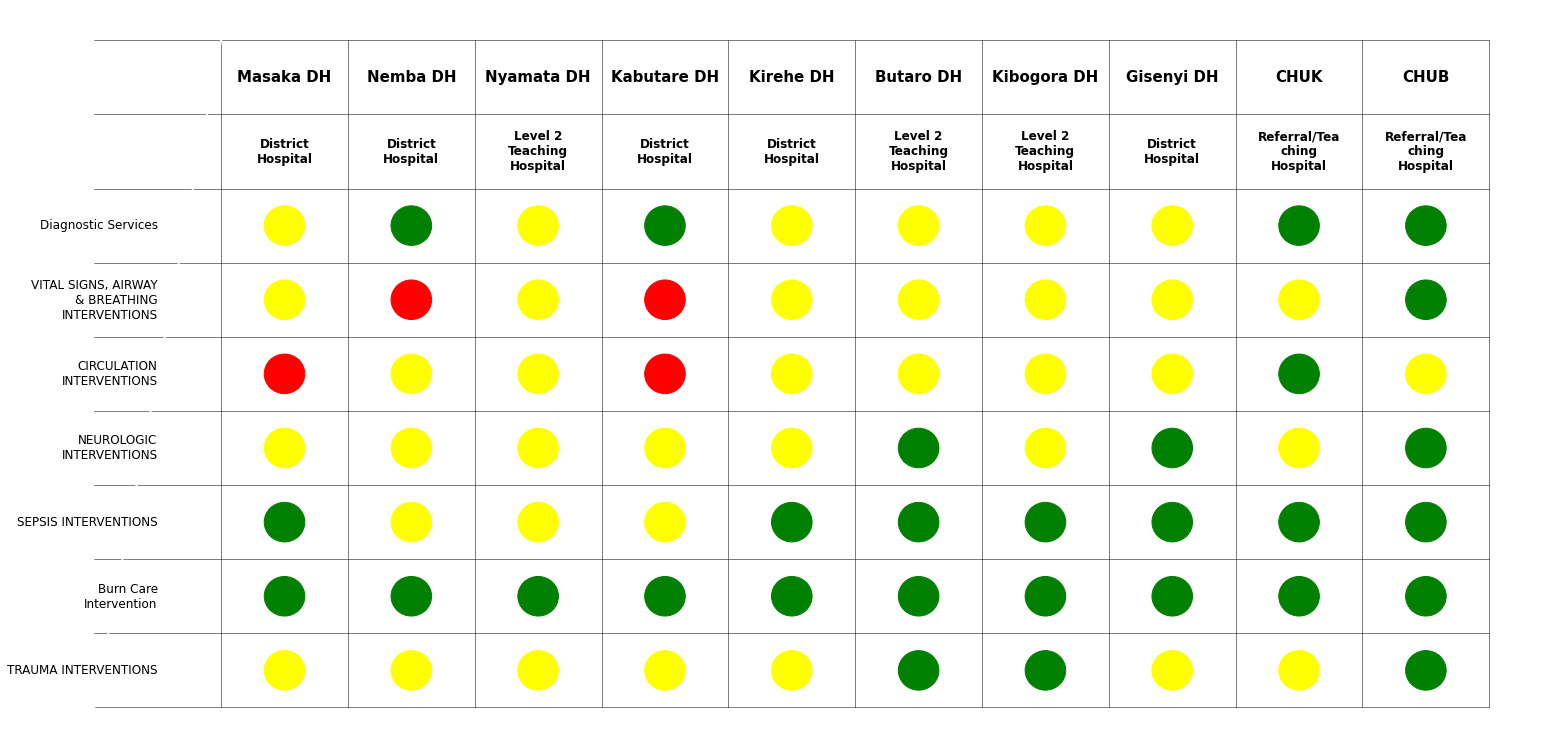

In [ ]:
refined_stoplight_chart(
    df= data ,
    hospital_name_col="hospital_name",
    hospital_level_col="hospital_level",
    category_cols=['Diagnostic Services','VITAL SIGNS, AIRWAY & BREATHING INTERVENTIONS','CIRCULATION INTERVENTIONS','NEUROLOGIC INTERVENTIONS','SEPSIS INTERVENTIONS','Burn Care Intervention','TRAUMA INTERVENTIONS'],
    save_path="Stop_light_chart.png"
    )

In [ ]:
# data.iloc[:,1150:].columns

In [ ]:
# df.to_excel("/content/drive/MyDrive/Goal 3/WHO Heat Tool/Units_results.xlsx")

#### Consulting Services

In [ ]:
cons_data = pd.read_excel("consulting services.xlsx")

In [ ]:
cons_data.columns

Index(['Hospital name', 'hospital_level', 'Unit name', 'General surgery',
       'Orthopedics', 'Anaesthesia', 'Paediatrics', 'Mental health Service',
       'Plastic and reconstructive Surgeon', 'Consulting Services Score'],
      dtype='object')

C:\Users\ishim\AppData\Local\Temp\ipykernel_32228\2572794626.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=cons_data, x="Hospital name", y="Consulting Services Score", hue="Unit name", ci=None)


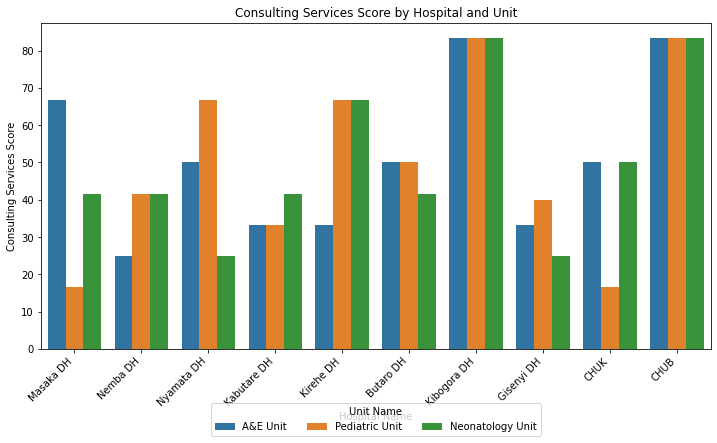

In [ ]:

plt.figure(figsize=(12, 6))
sns.barplot(data=cons_data, x="Hospital name", y="Consulting Services Score", hue="Unit name", ci=None)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Labels and title
plt.xlabel("Hospital Name")
plt.ylabel("Consulting Services Score")
plt.title("Consulting Services Score by Hospital and Unit")

# Move legend below and make it horizontal
plt.legend(title="Unit Name", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()


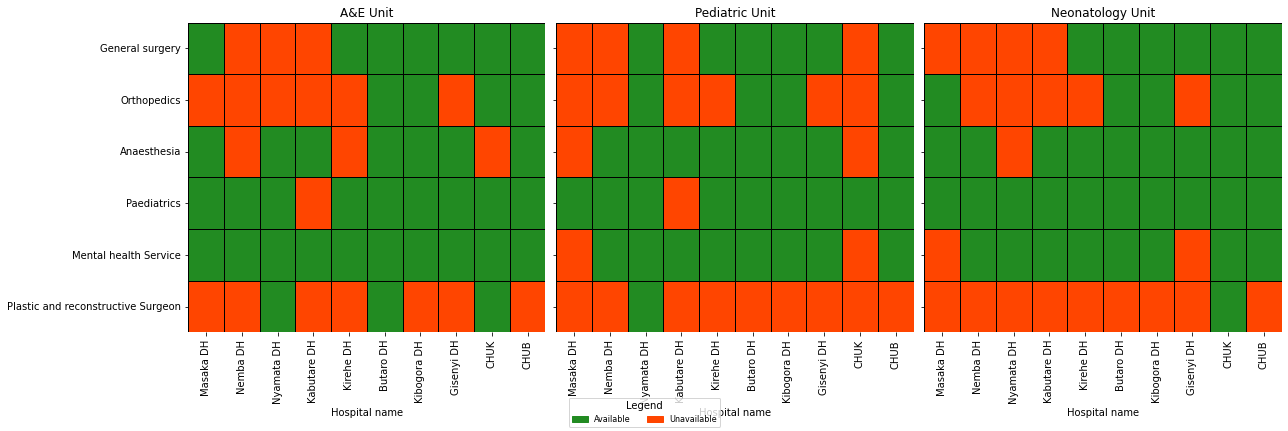

In [ ]:


# Define service columns
services = ['General surgery', 'Orthopedics', 'Anaesthesia', 'Paediatrics',
            'Mental health Service', 'Plastic and reconstructive Surgeon']

# Create figure for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Unique hospital levels
hospital_levels = cons_data['Unit name'].unique()

# Custom colormap: Red (0), Green (>0)
cmap = sns.color_palette(["orangered", "forestgreen"])

# Generate heatmaps for each hospital level
for i, level in enumerate(hospital_levels):
    # Filter data for the current hospital level
    level_data = cons_data[cons_data['Unit name'] == level]

    # Pivot table (Hospitals as columns, Services as rows)
    heatmap_data = level_data.set_index("Hospital name")[services].T

    # Convert values to binary (0 = Red, 1 = Green)
    binary_data = (heatmap_data > 0).astype(int)

    # Plot heatmap
    sns.heatmap(binary_data, cmap=cmap, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black")

    # Title and labels
    axes[i].set_title(f"{level}")
    # axes[i].set_xlabel("Hospital Name")
    # axes[i].set_ylabel("Services")
# Create a custom legend
red_patch = mpatches.Patch(color='orangered', label='Unavailable')
green_patch = mpatches.Patch(color='forestgreen', label='Available')

# Add legend below the plots
plt.figlegend(handles=[green_patch, red_patch], loc="lower center", ncol=2, title="Legend", fontsize=8)

# Adjust layout to fit legend
plt.subplots_adjust(bottom=0.2)
# Adjust layout
plt.tight_layout()
plt.show()


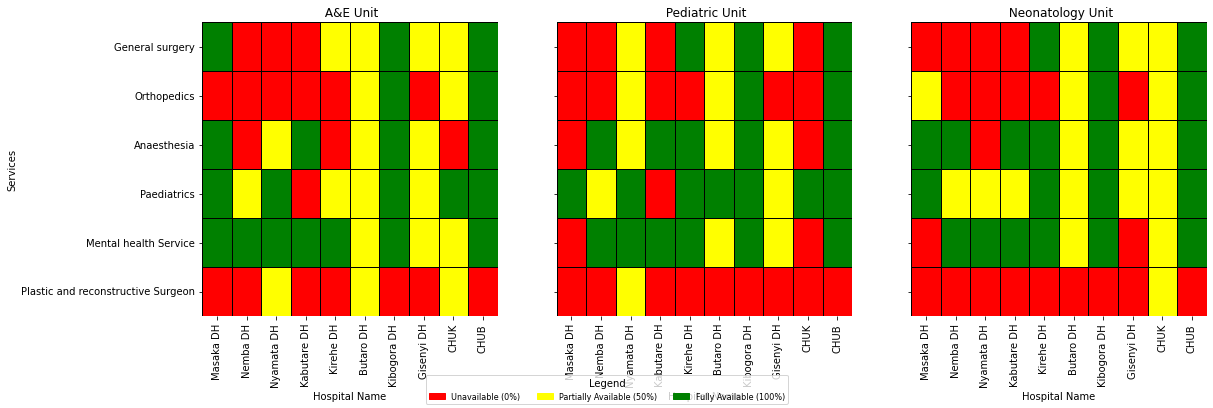

In [ ]:


# Sample DataFrame (Replace with actual data)
# cons_data = pd.read_csv("your_data.csv")

# Define service columns
services = ['General surgery', 'Orthopedics', 'Anaesthesia', 'Paediatrics',
            'Mental health Service', 'Plastic and reconstructive Surgeon']

# Create figure for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Unique hospital levels
hospital_levels = cons_data['Unit name'].unique()

# Define the custom colormap: Red (0), Yellow (50), Green (100)
colors = ["red", "yellow", "green"]
cmap = ListedColormap(colors)
bounds = [0, 25, 75, 100]  # Define threshold values
norm = BoundaryNorm(bounds, cmap.N)

# Generate heatmaps for each hospital level
for i, level in enumerate(hospital_levels):
    # Filter data for the current hospital level
    level_data = cons_data[cons_data['Unit name'] == level]

    # Pivot table (Hospitals as columns, Services as rows)
    heatmap_data = level_data.set_index("Hospital name")[services].T

    # Plot heatmap with custom colors
    sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black")

    # Title and labels
    axes[i].set_title(f" {level}")
    axes[i].set_xlabel("Hospital Name")

# Set common y-axis label
axes[0].set_ylabel("Services")

# Create a custom legend
red_patch = mpatches.Patch(color='red', label='Unavailable (0%)')
yellow_patch = mpatches.Patch(color='yellow', label='Partially Available (50%)')
green_patch = mpatches.Patch(color='green', label='Fully Available (100%)')

# Add legend below the plots
plt.figlegend(handles=[red_patch, yellow_patch, green_patch], loc="lower center", ncol=3, title="Legend", fontsize=8)

# Adjust layout to fit legend
plt.subplots_adjust(bottom=0.2)

plt.show()


In [ ]:
cons_data = pd.read_excel("consulting services.xlsx", sheet_name="Sheet6")


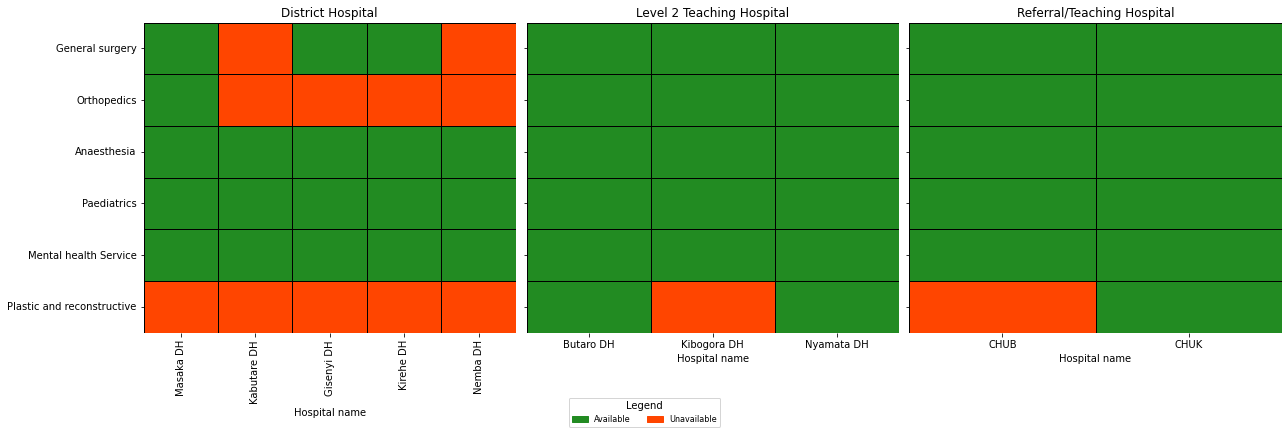

In [ ]:
# Define service columns
services = ['General surgery', 'Orthopedics', 'Anaesthesia', 'Paediatrics',
            'Mental health Service', 'Plastic and reconstructive']

# Create figure for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Unique hospital levels
hospital_levels = cons_data['Hospital level'].unique()

# Custom colormap: Red (0), Green (>0)
cmap = sns.color_palette(["orangered", "forestgreen"])

# Generate heatmaps for each hospital level
for i, level in enumerate(hospital_levels):
    # Filter data for the current hospital level
    level_data = cons_data[cons_data['Hospital level'] == level]

    # Pivot table (Hospitals as columns, Services as rows)
    heatmap_data = level_data.set_index("Hospital name")[services].T

    # Convert values to binary (0 = Red, 1 = Green)
    binary_data = (heatmap_data > 0).astype(int)

    # Plot heatmap
    sns.heatmap(binary_data, cmap=cmap, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black")

    # Title and labels
    axes[i].set_title(f"{level}")
    # axes[i].set_xlabel("Hospital Name")
    # axes[i].set_ylabel("Services")
# Create a custom legend
red_patch = mpatches.Patch(color='orangered', label='Unavailable')
green_patch = mpatches.Patch(color='forestgreen', label='Available')

# Add legend below the plots
plt.figlegend(handles=[green_patch, red_patch], loc="lower center", ncol=2, title="Legend", fontsize=8)

# Adjust layout to fit legend
plt.subplots_adjust(bottom=0.2)
# Adjust layout
plt.tight_layout()
plt.show()


### Availability of point of care testing

In [ ]:
point_data = pd.read_excel("point_of_care_testing_doc.xlsx")

In [ ]:
# point_data

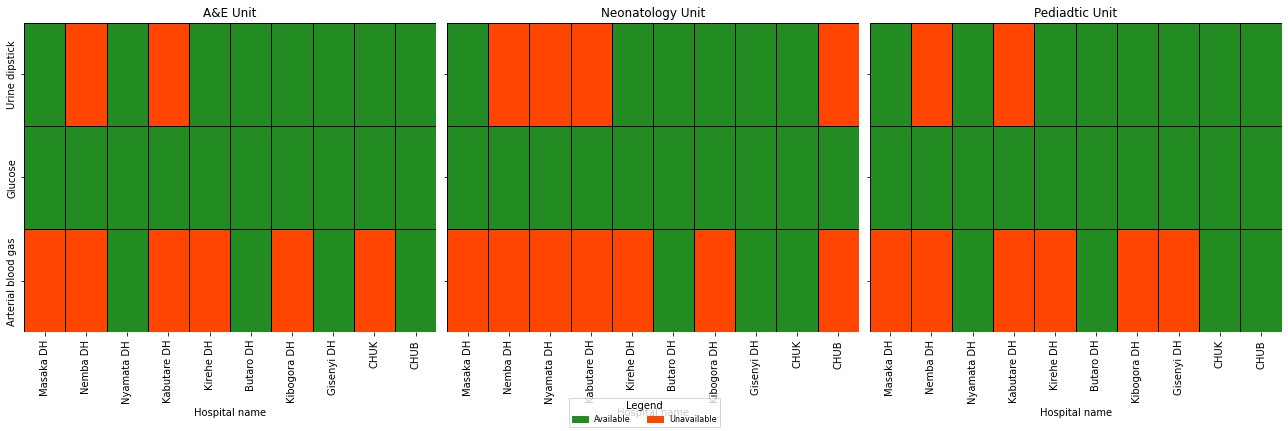

In [ ]:


# Define service columns
services = ['Urine dipstick','Glucose','Arterial blood gas']

# Create figure for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Unique hospital levels
hospital_levels = point_data['Unit name'].unique()

# Custom colormap: Red (0), Green (>0)
cmap = sns.color_palette(["orangered", "forestgreen"])

# Generate heatmaps for each hospital level
for i, level in enumerate(hospital_levels):
    # Filter data for the current hospital level
    level_data = point_data[point_data['Unit name'] == level]

    # Pivot table (Hospitals as columns, Services as rows)
    heatmap_data = level_data.set_index("Hospital name")[services].T

    # Convert values to binary (0 = Red, 1 = Green)
    binary_data = (heatmap_data > 0).astype(int)

    # Plot heatmap
    sns.heatmap(binary_data, cmap=cmap, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black")

    # Title and labels
    axes[i].set_title(f"{level}")
    # axes[i].set_xlabel("Hospital Name")
    # axes[i].set_ylabel("Services")
# Create a custom legend
red_patch = mpatches.Patch(color='orangered', label='Unavailable')
green_patch = mpatches.Patch(color='forestgreen', label='Available')

# Add legend below the plots
plt.figlegend(handles=[green_patch, red_patch], loc="lower center", ncol=2, title="Legend", fontsize=8)

# Adjust layout to fit legend
plt.subplots_adjust(bottom=0.2)
# Adjust layout
plt.tight_layout()
plt.show()


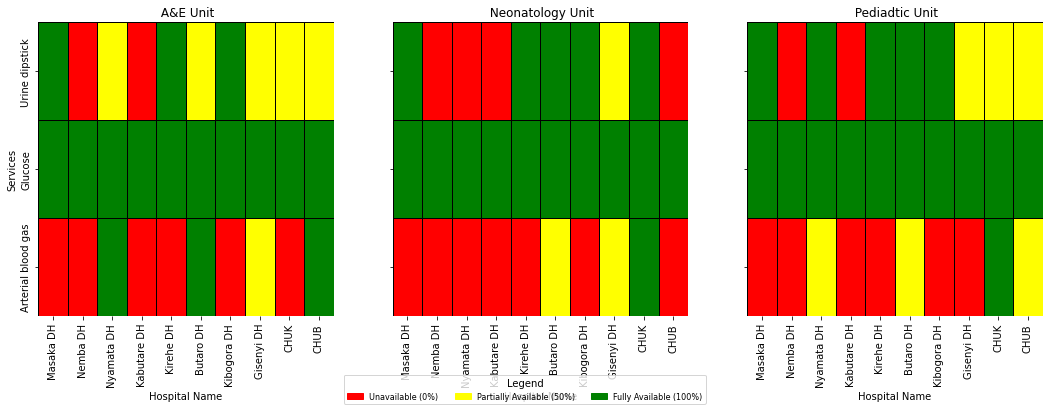

In [ ]:


# Sample DataFrame (Replace with actual data)
# cons_data = pd.read_csv("your_data.csv")

# Define service columns
services = ['Urine dipstick','Glucose','Arterial blood gas']

# Create figure for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Unique hospital levels
hospital_levels = point_data['Unit name'].unique()

# Define the custom colormap: Red (0), Yellow (50), Green (100)
colors = ["red", "yellow", "green"]
cmap = ListedColormap(colors)
bounds = [0, 25, 75, 100]  # Define threshold values
norm = BoundaryNorm(bounds, cmap.N)

# Generate heatmaps for each hospital level
for i, level in enumerate(hospital_levels):
    # Filter data for the current hospital level
    level_data = point_data[point_data['Unit name'] == level]

    # Pivot table (Hospitals as columns, Services as rows)
    heatmap_data = level_data.set_index("Hospital name")[services].T

    # Plot heatmap with custom colors
    sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black")

    # Title and labels
    axes[i].set_title(f" {level}")
    axes[i].set_xlabel("Hospital Name")

# Set common y-axis label
axes[0].set_ylabel("Services")

# Create a custom legend
red_patch = mpatches.Patch(color='red', label='Unavailable (0%)')
yellow_patch = mpatches.Patch(color='yellow', label='Partially Available (50%)')
green_patch = mpatches.Patch(color='green', label='Fully Available (100%)')

# Add legend below the plots
plt.figlegend(handles=[red_patch, yellow_patch, green_patch], loc="lower center", ncol=3, title="Legend", fontsize=8)

# Adjust layout to fit legend
plt.subplots_adjust(bottom=0.2)

plt.show()


In [ ]:
# generate_hospital_service_heatmap(df = point_data, services = ['Urine dipstick', 'Glucose', 'Arterial blood gas'])

In [ ]:
point_data

,Hospital name,Hospital level,Urine dipstick,Why no urine dipstick,Glucose,Arterial blood gas,Why no arterial blood gas,Unit name
0,Masaka DH,District Hospital,100,NaN,100,0,Not at level of district,A&E Unit
1,Nemba DH,District Hospital,0,Absent Equipment,100,0,Absent Equipment,A&E Unit
2,Nyamata DH,Level 2 Teaching Hospital,50,Exam is send to lab,100,100,NaN,A&E Unit
3,Kabutare DH,District Hospital,0,Absent Equipment,100,0,Absent Equipment and Training,A&E Unit
4,Kirehe DH,District Hospital,100,NaN,100,0,Not at level of district,A&E Unit
5,Butaro DH,Level 2 Teaching Hospital,50,Exam is send to lab,100,100,NaN,A&E Unit
6,Kibogora DH,Level 2 Teaching Hospital,100,NaN,100,0,Absent Equipment,A&E Unit
7,Gisenyi DH,District Hospital,50,Exam is send to lab,100,50,They heard anesthesiologist have it but not sure,A&E Unit
8,CHUK,Referral/Teaching Hospital,50,Absent Equipment,100,0,It's done PICU,A&E Unit
9,CHUB,Referral/Teaching Hospital,50,Stockout supplies,100,100,NaN,A&E Unit


In [ ]:
point_data = pd.read_excel("point_of_care_testing_doc.xlsx", sheet_name="Sheet2")

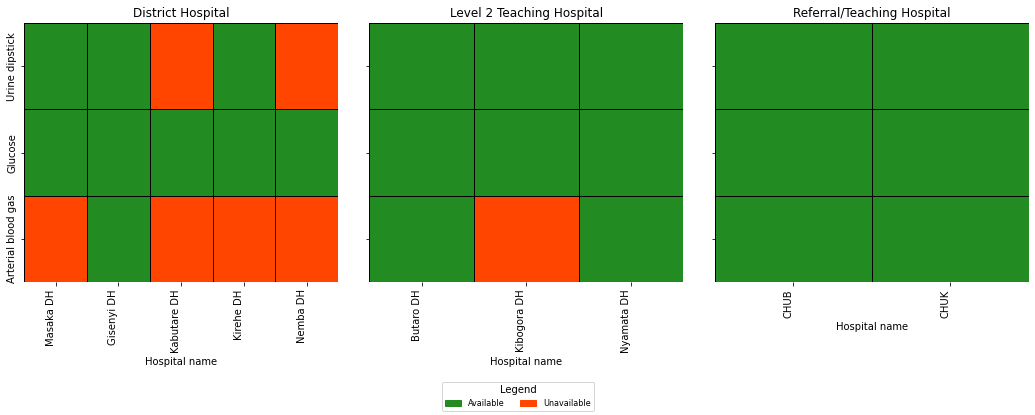

In [ ]:
# Define service columns
services = ['Urine dipstick', 'Glucose', 'Arterial blood gas']
hospital_levels = sorted(point_data['Hospital level'].unique())

# Create figure for subplots
fig, axes = plt.subplots(1, len(hospital_levels), figsize=(6 * len(hospital_levels), 6), sharey=True)

# Generate heatmaps for each hospital level
for i, level in enumerate(hospital_levels):
    # Filter data for the current hospital level
    level_data = point_data[point_data['Hospital level'] == level]
    heatmap_data = level_data.set_index("Hospital name")[services].T.fillna(0)
    binary_data = (heatmap_data > 0).astype(int)

    # Explicitly ensure Referral/Teaching Hospitals appear fully green
    if level == "Referral/Teaching Hospital":
        binary_data[:] = 1

    # Plot heatmap without numbers inside
    sns.heatmap(binary_data, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black",
                xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index,
                cmap=["orangered", "forestgreen"], vmin=0, vmax=1, annot=False)

    # Title and labels
    axes[i].set_title(f"{level}")

    # Rotate x-axis labels for readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha="right")

# Create a custom legend
red_patch = mpatches.Patch(color='orangered', label='Unavailable')
green_patch = mpatches.Patch(color='forestgreen', label='Available')

# Add legend below the plots
plt.figlegend(handles=[green_patch, red_patch], loc="lower center", ncol=2, title="Legend", fontsize=8)
plt.subplots_adjust(bottom=0.3, top=0.9, wspace=0.1)
plt.show()


In [ ]:
def plot_service_availability_heatmap(df, services):
    """
    Generate heatmaps for each hospital level showing service availability.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing 'Unit name', 'Hospital name', and service availability columns.
    services (list): List of services to include in the heatmap.
    """
    
    # Unique hospital levels
    hospital_levels = df['Hospital level'].unique()
    
    # Create figure for subplots
    fig, axes = plt.subplots(1, len(hospital_levels), figsize=(6 * len(hospital_levels), 6), sharey=True)
    
    # Define the custom colormap: Red (0), Yellow (50), Green (100)
    colors = ["red", "yellow", "green"]
    cmap = ListedColormap(colors)
    bounds = [0, 25, 75, 100]  # Define threshold values
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Ensure axes is iterable even if there's only one subplot
    if len(hospital_levels) == 1:
        axes = [axes]
    
    # Generate heatmaps for each hospital level
    for i, level in enumerate(hospital_levels):
        # Filter data for the current hospital level
        level_data = df[df['Hospital level'] == level]
        
        # Pivot table (Hospitals as columns, Services as rows)
        heatmap_data = level_data.set_index("Hospital name")[services].T
        
        # Plot heatmap with custom colors
        sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black")
        
        # Title and labels
        axes[i].set_title(f"{level}")
        axes[i].set_xlabel("Hospital Name")
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")
    
    # Set common y-axis label
    # axes[0].set_ylabel("Services")
    
    # Create a custom legend
    red_patch = mpatches.Patch(color='red', label='Unavailable (0%)')
    yellow_patch = mpatches.Patch(color='yellow', label='Partially Available (50%)')
    green_patch = mpatches.Patch(color='green', label='Fully Available (100%)')
    
    # Add legend below the plots
    plt.figlegend(handles=[red_patch, yellow_patch, green_patch], loc="lower center", ncol=3, title="Legend", fontsize=8)
    
    # Adjust layout to fit legend
    plt.subplots_adjust(bottom=0.2)
    
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

def plot_service_availability_heatmap_two_way_category(df, services):
    """
    Plots a heatmap showing the availability of specified services across different hospital levels.

    Parameters:
    df (pd.DataFrame): The DataFrame containing hospital data.
    services (list): A list of services to visualize.

    Returns:
    None
    """
    # Get unique hospital levels in sorted order
    hospital_levels = sorted(df['Hospital level'].unique())

    # Create figure for subplots
    fig, axes = plt.subplots(1, len(hospital_levels), figsize=(6 * len(hospital_levels), 6), sharey=True)

    # Ensure axes is iterable when there's only one hospital level
    if len(hospital_levels) == 1:
        axes = [axes]

    # Generate heatmaps for each hospital level
    for i, level in enumerate(hospital_levels):
        # Filter data for the current hospital level
        level_data = df[df['Hospital level'] == level]
        heatmap_data = level_data.set_index("Hospital name")[services].T.fillna(0)
        binary_data = (heatmap_data > 0).astype(int)

        # Ensure Referral/Teaching Hospitals appear fully green
        if level == "Referral/Teaching Hospital":
            binary_data[:] = 1

        # Plot heatmap
        sns.heatmap(binary_data, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black",
                    xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index,
                    cmap=["orangered", "forestgreen"], vmin=0, vmax=1, annot=False)

        # Set title
        axes[i].set_title(f"{level}")

        # Rotate x-axis labels for readability
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

    # Create a custom legend
    red_patch = mpatches.Patch(color='orangered', label='Unavailable')
    green_patch = mpatches.Patch(color='forestgreen', label='Available')

    # Add legend below the plots
    plt.figlegend(handles=[green_patch, red_patch], loc="lower center", ncol=2, title="Legend", fontsize=8)
    plt.subplots_adjust(bottom=0.3, top=0.9, wspace=0.1)
    plt.show()


#### Signal Function Performance

#### 1. Vital Signs

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

def plot_service_availability_heatmap(df, services, title="Service Availability Heatmap"):
    """
    Plots a heatmap showing the availability of specified services across different hospital levels.
    Green represents unavailable (0), Orange represents available (1).
    
    Referral/Teaching Hospitals reflect actual data values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing hospital data.
    services (list): A list of services to visualize.
    title (str): The title of the heatmap.

    Returns:
    None
    """
    # Get unique hospital levels in sorted order
    hospital_levels = sorted(df['Hospital level'].unique())

    # Create figure for subplots
    fig, axes = plt.subplots(1, len(hospital_levels), figsize=(6 * len(hospital_levels), 6), sharey=True)
    fig.suptitle(title, fontsize=16, fontweight='bold')  # Set the title of the figure

    # Ensure axes is iterable when there's only one hospital level
    if len(hospital_levels) == 1:
        axes = [axes]

    # Generate heatmaps for each hospital level
    for i, level in enumerate(hospital_levels):
        # Filter data for the current hospital level
        level_data = df[df['Hospital level'] == level]
        heatmap_data = level_data.set_index("Hospital name")[services].T.fillna(0)
        binary_data = (heatmap_data > 0).astype(int)  # Convert to binary (1=available, 0=unavailable)

        # Plot heatmap with actual values for Referral/Teaching Hospitals
        sns.heatmap(binary_data, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black",
                    xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index,
                    cmap=["forestgreen", "orangered"], vmin=0, vmax=1, annot=False)

        # Set title for each hospital level
        axes[i].set_title(f"{level}")

        # Rotate x-axis labels for readability
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

    # Create a custom legend with **switched colors**
    green_patch = mpatches.Patch(color='forestgreen', label='Unavailable')
    orange_patch = mpatches.Patch(color='orangered', label='Available')

    # Add legend below the plots
    plt.figlegend(handles=[green_patch, orange_patch], loc="lower center", ncol=2, title="Legend", fontsize=8)
    plt.subplots_adjust(bottom=0.3, top=0.9, wspace=0.1)
    plt.show()
    
    
import pandas as pd
from tabulate import tabulate

def transform_service_availability(df, service_columns):
    """Transforms service availability scores (100, 50, 0) into categorical labels."""
    mapping = {100: 'Fully Available', 50: 'Partially Available', 0: 'Unavailable'}
    for col in service_columns:
        if col in df.columns:
            df[col] = df[col].replace(mapping)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df

def summarize_service_availability(df, service_columns):
    """Summarizes service availability counts and percentages."""

    overall_summary = {}
    level_summary = {}

    for service in service_columns:
        if service not in df.columns:
            print(f"Warning: Column '{service}' not found in DataFrame.")
            continue  # Skip to the next service

        overall_counts = df[service].value_counts().to_dict()
        overall_summary[service] = overall_counts

        for level in df['Hospital level'].unique():
            level_df = df[df['Hospital level'] == level]
            level_counts = level_df[service].value_counts().to_dict()

            if level not in level_summary:
                level_summary[level] = {}
            level_summary[level][service] = level_counts

    return overall_summary, level_summary


def format_summary_table(summary_data):
    """Formats summary data with counts and percentages."""

    formatted_table = {}
    for service, counts in summary_data.items():
        total = sum(counts.values()) if counts else 0  # Handle cases where counts might be empty
        formatted_row = {}
        for availability, count in counts.items():
            percentage = (count / total) * 100 if total > 0 else 0
            formatted_row[availability] = f"({count} - {percentage:.1f}%)"
        formatted_table[service] = formatted_row

    return pd.DataFrame.from_dict(formatted_table, orient='index').fillna("(0 - 0.0%)") # Fill missing with 0


def display_tables(overall_formatted, level_formatted):
    """Displays tables using tabulate."""
    print("\nOverall Service Availability Summary:")
    print(tabulate(overall_formatted, headers='keys', tablefmt='pretty'))

    print("\nService Availability Summary by Hospital Level:")
    for level, df in level_formatted.items():
        print(f"\nHospital Level: {level}")
        print(tabulate(df, headers='keys', tablefmt='pretty'))


def export_to_excel(overall_formatted, level_formatted):
    """Exports to Excel, sanitizing sheet names."""
    with pd.ExcelWriter('service_availability_summary.xlsx') as writer:
        overall_formatted.to_excel(writer, sheet_name='Overall Summary')

        for level, df in level_formatted.items():
            # Sanitize the sheet name by replacing invalid characters
            safe_sheet_name = level.replace("/", "_").replace("\\", "_")  # Replace / and \ with _
            df.to_excel(writer, sheet_name=f'Level {safe_sheet_name}')



In [ ]:
# data

In [ ]:
import pandas as pd

# Creating a DataFrame
vital_data = pd.DataFrame()
vital_data['Hospital name'] = data["hospital_name_sign"]

# Hospital mapping dictionary
hospital_mapping = {
    1: "CHUK",
    2: "Masaka DH",
    3: "Nyamata DH",
    4: "Kirehe DH",
    5: "Butaro DH",
    6: "Nemba DH",
    7: "CHUB",
    8: "Kabutare DH",
    9: "Kibogora DH",
    10: "Gisenyi DH"
}

hospital_levels = {
    "CHUK": "Referral/Teaching Hospital",
    "Masaka DH": "District Hospital",
    "Nyamata DH": "Level 2 Teaching Hospital",
    "Kirehe DH": "District Hospital",
    "Butaro DH": "Level 2 Teaching Hospital",
    "Nemba DH": "District Hospital",
    "CHUB": "Referral/Teaching Hospital",
    "Kabutare DH": "District Hospital",
    "Kibogora DH": "Level 2 Teaching Hospital",
    "Gisenyi DH": "District Hospital"
}

# Replace numeric values with hospital names
vital_data['Hospital name'] = vital_data['Hospital name'].map(hospital_mapping)

# Ensure hospital levels are correctly mapped
vital_data['Hospital level'] = vital_data['Hospital name'].map(hospital_levels)



In [ ]:
vital_data['vital signs measured in the triage area'] = data["vital_signs_rate"]
vital_data['vital signs measured in the Emergency Unit'] = data["emergency_unit_signs"]
vital_data['vital signs measured intermittently in the neonatal HDU'] = data["dependency_unit_signs"]
vital_data['vital signs measured continuously in the neonatal HDU'] = data["neonatal_high_unit"]
vital_data['vital signs measured intermittently in the pediatric HDU'] = data["pediatric_high_unit"]
vital_data['Are vital signs measured continuously in the pediatric HDU'] = data["continous_measured_signs"]
# vital_data['System for reporting urgent lab results in a timely fashion'] = data["antibiotic"]

# vital_data['Blood smear test for malaria'] = data["initial_wound"]
# vital_data['System for reporting critical lab results in a timely fashion  '] = data["tetanus"]
# vital_data['Rabies vaccination or IVIg as appropriate'] = data["rabies"]

In [ ]:
vital_data.columns

Index(['Hospital name', 'Hospital level', 'Full blood count',
       'Coagulation profile (PT/PTT)', 'Electrolytes', 'BUN and creatinine',
       'Urine microscopy', 'Cross matching for blood and blood products',
       'System for reporting urgent lab results in a timely fashion',
       'Blood smear test for malaria',
       'System for reporting critical lab results in a timely fashion  '],
      dtype='object')

In [ ]:
service_cols = ['Cervical spine immobilization ',
       'Three-way dressing for sucking chest wound ',
       'Fasciotomy or escharotomy for compartment syndrome ',
       'Opiate analgesia administration', 'Fracture immobilization ',
       'Closed reduction of fracture or dislocation ',
       'Antibiotic administration for open fracture ', 'Initial wound care ',
       'Tetanus vaccination or IVIg as appropriate ',
       'Rabies vaccination or IVIg as appropriate']

vital_data = transform_service_availability(vital_data, service_cols)
overall_summary, level_summary = summarize_service_availability(vital_data, service_cols)

overall_formatted = format_summary_table(overall_summary)
level_formatted = {level: format_summary_table(data) for level, data in level_summary.items()}

display_tables(overall_formatted, level_formatted)
export_to_excel(overall_formatted, level_formatted)


Overall Service Availability Summary:


Service Availability Summary by Hospital Level:


C:\Users\ishim\AppData\Local\Temp\ipykernel_32228\1941715777.py:126: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  with pd.ExcelWriter('service_availability_summary.xlsx') as writer:


#### 2. Human Resources

A. Number of non-rotating providers assigned to emergency unit/neonatology/pediatric 

In [ ]:
hr_data = data[["hospital_name","emergency_units", "outpatient_visits_per_year", "inpatient_admissions_per_year","emergency_care_beds","nurses_nurse_midwives", "nurses_nurse_midwives_2", "nurses_nurse_midwives_3",
    "nurses_midwives", "nurses_midwives_2", "nurses_midwives_3",
    "medical_officers", "medical_officers_2", "medical_officers_3",
    "medical_officers_number", "medical_officers_number_2", "medical_officers_number_3",
    "pediatric_emergency_doctor", "pediatric_emergency_doctor_2", "pediatric_emergency_doctor_3",
    "pediatric_doctors_number", "pediatric_doctors_number_2", "pediatric_doctors_number_3",
    "neonatologist_number", "neonatologist_number_2", "neonatologist_number_3",
    "neonatologists", "neonatologists_2", "neonatologists_3",
    "pediatrician_number", "pediatrician_number_2", "pediatricians",
    "pediatricians_2", "pediatricians_3"]]
# hr_data.to_excel("H resource data.xlsx")

In [ ]:
# hr_data["Nurses/nurse midwives"] = hr_data["nurses_nurse_midwives"] + hr_data["nurses_nurse_midwives_2"] + hr_data["nurses_nurse_midwives_3"] + hr_data["nurses_midwives"] + hr_data["nurses_midwives_2"] + hr_data["nurses_midwives_3"]
# hr_data["Medical officers"] = hr_data["medical_officers"] + hr_data["medical_officers_2"] + hr_data["medical_officers_3"] + hr_data["medical_officers_number"] + hr_data["medical_officers_number_2"] + hr_data["medical_officers_number_3"]
# hr_data["pediatric_emergency_doctor"] = hr_data["pediatric_emergency_doctor"] + hr_data["pediatric_emergency_doctor_2"] + hr_data["pediatric_emergency_doctor_3"] + hr_data["pediatric_doctors_number"] + hr_data["pediatric_doctors_number_2"] + hr_data["pediatric_doctors_number_3"]
# hr_data["Neonatologist"] = hr_data["neonatologist_number"] + hr_data["neonatologist_number_2"]+ hr_data["neonatologist_number_3"] + hr_data["neonatologists"] + hr_data["neonatologists_2"] + hr_data["neonatologists_3"]
# hr_data["Pediatrician"] = hr_data["pediatrician_number"] + hr_data["pediatrician_number_2"] + hr_data["pediatrician_number_2"] + hr_data ["pediatricians"] + hr_data["pediatricians_2"] + hr_data["pediatricians_3"]

In [ ]:
import pandas as pd

# Convert columns to numeric
cols_to_convert = ["emergency_units", "outpatient_visits_per_year", "inpatient_admissions_per_year","emergency_care_beds",
    "nurses_nurse_midwives", "nurses_nurse_midwives_2", "nurses_nurse_midwives_3",
    "nurses_midwives", "nurses_midwives_2", "nurses_midwives_3",
    "medical_officers", "medical_officers_2", "medical_officers_3",
    "medical_officers_number", "medical_officers_number_2", "medical_officers_number_3",
    "pediatric_emergency_doctor", "pediatric_emergency_doctor_2", "pediatric_emergency_doctor_3",
    "pediatric_doctors_number", "pediatric_doctors_number_2", "pediatric_doctors_number_3",
    "neonatologist_number", "neonatologist_number_2", "neonatologist_number_3",
    "neonatologists", "neonatologists_2", "neonatologists_3",
    "pediatrician_number", "pediatrician_number_2", "pediatricians",
    "pediatricians_2", "pediatricians_3"
]

# Convert all specified columns to numeric
hr_data[cols_to_convert] = hr_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')
hr_data = hr_data.fillna(0)
# # Now perform the summation safely
hr_data["Nurses/nurse midwives"] = hr_data["nurses_nurse_midwives"] + hr_data["nurses_nurse_midwives_2"] + hr_data["nurses_nurse_midwives_3"] + hr_data["nurses_midwives"] + hr_data["nurses_midwives_2"] + hr_data["nurses_midwives_3"]
hr_data["Medical officers"] = hr_data["medical_officers"] + hr_data["medical_officers_2"] + hr_data["medical_officers_3"] + hr_data["medical_officers_number"] + hr_data["medical_officers_number_2"] + hr_data["medical_officers_number_3"]
hr_data["pediatric_emergency_doctor"] = hr_data["pediatric_emergency_doctor"] + hr_data["pediatric_emergency_doctor_2"] + hr_data["pediatric_emergency_doctor_3"] + hr_data["pediatric_doctors_number"] + hr_data["pediatric_doctors_number_2"] + hr_data["pediatric_doctors_number_3"]
hr_data["Neonatologist"] = hr_data["neonatologist_number"] + hr_data["neonatologist_number_2"] + hr_data["neonatologist_number_3"] + hr_data["neonatologists"] + hr_data["neonatologists_2"] + hr_data["neonatologists_3"]
hr_data["Pediatrician"] = hr_data["pediatrician_number"] + hr_data["pediatrician_number_2"] + hr_data["pediatricians"] + hr_data["pediatricians_2"] + hr_data["pediatricians_3"]


In [ ]:
# hr_data["Nurses/nurse midwives"] = hr_data["nurses_nurse_midwives"] + hr_data["nurses_midwives"]
# hr_data["Medical officers"] = hr_data["medical_officers"] + hr_data["medical_officers_number"]
# hr_data["pediatric_emergency_doctor"] = hr_data["pediatric_emergency_doctor"] + hr_data["pediatric_doctors_number"]
# hr_data["Neonatologist"] = hr_data["neonatologist_number"] + hr_data["neonatologists"]
# hr_data["Pediatrician"] = hr_data["pediatrician_number"] + hr_data["pediatricians"]


In [ ]:
hr_data

,hospital_name,emergency_units,outpatient_visits_per_year,inpatient_admissions_per_year,emergency_care_beds,nurses_nurse_midwives,nurses_nurse_midwives_2,nurses_nurse_midwives_3,nurses_midwives,nurses_midwives_2,...,neonatologists_3,pediatrician_number,pediatrician_number_2,pediatricians,pediatricians_2,pediatricians_3,Nurses/nurse midwives,Medical officers,Neonatologist,Pediatrician
0,Masaka DH,2571.5,7651.25,3490.5,27,19,14.0,8,0,1,...,0,2,2,0,0,0,42.0,18,0,4
1,Nemba DH,2226.0,1853.00,1490.0,7,13,8.0,4,0,1,...,0,0,0,0,1,1,28.0,22,0,2
2,Nyamata DH,1581.0,2745.00,3303.0,5,0,0.0,15,15,0,...,0,0,1,2,0,0,30.0,3,0,3
3,Kabutare DH,1673.0,1509.00,1751.0,10,15,10.0,7,0,0,...,0,0,0,1,1,0,32.0,39,0,2
4,Kirehe DH,2864.0,1465.00,1212.0,0,9,13.0,5,0,0,...,0,1,1,0,0,0,27.0,16,3,2
5,Butaro DH,65.6,640.80,1784.6,19,9,10.0,15,0,0,...,0,0,1,1,0,0,34.0,15,2,2
6,Kibogora DH,194.0,1832.00,3262.0,0,15,11.0,9,0,0,...,0,1,1,0,0,0,35.0,3,0,2
7,Gisenyi DH,110.0,3373.00,3408.0,23,22,17.0,14,0,0,...,0,0,0,1,0,0,53.0,15,0,1
8,CHUK,2052.0,9132.00,1872.0,11,25,31.0,41,0,0,...,0,1,1,0,0,0,97.0,12,4,2
9,CHUB,0.0,10820.00,1699.0,3,0,21.0,23,20,0,...,0,0,0,5,5,5,64.0,3,0,15


In [ ]:
hr_data[["hospital_name","outpatient_visits_per_year", "inpatient_admissions_per_year" ,"emergency_care_beds","Nurses/nurse midwives","Medical officers","pediatric_emergency_doctor","Neonatologist","Pediatrician"]].to_excel("inpatient outpatient data.xlsx")

C:\Users\ishim\AppData\Local\Temp\ipykernel_32228\2109916883.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  hr_data[["hospital_name","outpatient_visits_per_year", "inpatient_admissions_per_year" ,"emergency_care_beds","Nurses/nurse midwives","Medical officers","pediatric_emergency_doctor","Neonatologist","Pediatrician"]].to_excel("inpatient outpatient data.xlsx")


In [ ]:
import pandas as pd

def calculate_inpatient_ratios_pivot(df, staff_services, inpatient_col, output_filename="inpatient_ratios.xlsx"):
    """
    Calculates inpatient ratios, pivots, and exports to Excel.

    Args:
        df: Pandas DataFrame.
        staff_services: List of staff service columns.
        inpatient_col: Inpatient admissions column name.
        output_filename: Name of the Excel file to export to.

    Returns:
        Pandas DataFrame or None if error.  Also exports to Excel.
    """

    if inpatient_col not in df.columns:
        print(f"Error: Inpatient column '{inpatient_col}' not found in DataFrame.")
        return None

    results = []

    for facility in df['hospital_name'].unique():
        facility_df = df[df['hospital_name'] == facility]
        total_inpatients = facility_df[inpatient_col].sum()

        row = {'Hospital name': facility}
        if total_inpatients == 0:
            for service in staff_services:
                row[f"{service} to inpatient ratio"] = "N/A (No Inpatients)"
            results.append(row)
            continue

        for service in staff_services:
            if service in facility_df.columns:
                total_staff = facility_df[service].sum()
                if total_staff == 0:
                    ratio = "N/A (No Staff)"
                else:
                    ratio = round(total_inpatients / total_staff) if total_staff > 0 else "N/A"
                row[f"{service} "] = ratio
            else:
                print(f"Warning: Staff service '{service}' not found in DataFrame for facility '{facility}'.")
                row[f"{service} to inpatient ratio"] = "N/A (Column Missing)"

        results.append(row)

    results_df = pd.DataFrame(results).set_index('Hospital name')

    # Export to Excel:
    try:
        results_df.to_excel(output_filename)
        print(f"Inpatient ratios exported to {output_filename}")
    except Exception as e:
        print(f"Error exporting to Excel: {e}")
        return None  # Return None if export fails

    return results_df  # Return DataFrame even if export is successful


In [ ]:
calculate_inpatient_ratios_pivot(df = hr_data, staff_services = ["Nurses/nurse midwives","Medical officers","pediatric_emergency_doctor","Neonatologist","Pediatrician"], inpatient_col = "emergency_units",output_filename="Emergency_hospital_ratios.xlsx")

Inpatient ratios exported to Emergency_hospital_ratios.xlsx


C:\Users\ishim\AppData\Local\Temp\ipykernel_32228\3890389509.py:52: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  results_df.to_excel(output_filename)


,Nurses/nurse midwives,Medical officers,pediatric_emergency_doctor,Neonatologist,Pediatrician,Nurses/nurse midwives to inpatient ratio,Medical officers to inpatient ratio,pediatric_emergency_doctor to inpatient ratio,Neonatologist to inpatient ratio,Pediatrician to inpatient ratio
Hospital name,,,,,,,,,,
Masaka DH,61.0,143.0,N/A (No Staff),N/A (No Staff),643.0,NaN,NaN,NaN,NaN,NaN
Nemba DH,80.0,101.0,N/A (No Staff),N/A (No Staff),1113.0,NaN,NaN,NaN,NaN,NaN
Nyamata DH,53.0,527.0,N/A (No Staff),N/A (No Staff),527.0,NaN,NaN,NaN,NaN,NaN
Kabutare DH,52.0,43.0,N/A (No Staff),N/A (No Staff),836.0,NaN,NaN,NaN,NaN,NaN
Kirehe DH,106.0,179.0,N/A (No Staff),955,1432.0,NaN,NaN,NaN,NaN,NaN
Butaro DH,2.0,4.0,N/A (No Staff),33,33.0,NaN,NaN,NaN,NaN,NaN
Kibogora DH,6.0,65.0,N/A (No Staff),N/A (No Staff),97.0,NaN,NaN,NaN,NaN,NaN
Gisenyi DH,2.0,7.0,N/A (No Staff),N/A (No Staff),110.0,NaN,NaN,NaN,NaN,NaN
CHUK,21.0,171.0,N/A (No Staff),513,1026.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Display specific columns and their summed result
cols = ["nurses_nurse_midwives", "nurses_nurse_midwives_2", "nurses_nurse_midwives_3",
        "nurses_midwives", "nurses_midwives_2", "nurses_midwives_3", "Nurses/nurse midwives"]
hr_data[cols]


,nurses_nurse_midwives,nurses_nurse_midwives_2,nurses_nurse_midwives_3,nurses_midwives,nurses_midwives_2,nurses_midwives_3,Nurses/nurse midwives
0,19,14.0,8,0,1,0,42.0
1,13,8.0,4,0,1,2,28.0
2,0,0.0,15,15,0,0,30.0
3,15,10.0,7,0,0,0,32.0
4,9,13.0,5,0,0,0,27.0
5,9,10.0,15,0,0,0,34.0
6,15,11.0,9,0,0,0,35.0
7,22,17.0,14,0,0,0,53.0
8,25,31.0,41,0,0,0,97.0
9,0,21.0,23,20,0,0,64.0


#### 2. Infrastructures

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_hospital_service_heatmaps(cons_data, services):
    """
    Generates heatmaps showing service availability across different hospital levels.
    
    Parameters:
    cons_data (DataFrame): The dataset containing hospital service availability.
    services (list): List of service column names to be visualized.
    """
    # Create figure for subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Unique hospital levels
    hospital_levels = cons_data['Unit name'].unique()
    
    # Define the custom colormap: Red (0), Yellow (50), Green (100)
    colors = ["red", "yellow", "green"]
    cmap = ListedColormap(colors)
    bounds = [0, 25, 75, 100]  # Define threshold values
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Generate heatmaps for each hospital level
    for i, level in enumerate(hospital_levels):
        # Filter data for the current hospital level
        level_data = cons_data[cons_data['Unit name'] == level]
        
        # Pivot table (Hospitals as columns, Services as rows)
        heatmap_data = level_data.set_index("Hospital name")[services].T
        
        # Plot heatmap with custom colors
        sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black")
        
        # Title and labels
        axes[i].set_title(f" {level}")
        axes[i].set_xlabel("Hospital Name")
    
    # Set common y-axis label
    axes[0].set_ylabel("Services")
    
    # Create a custom legend
    red_patch = mpatches.Patch(color='red', label='Unavailable (0%)')
    yellow_patch = mpatches.Patch(color='yellow', label='Partially Available (50%)')
    green_patch = mpatches.Patch(color='green', label='Fully Available (100%)')
    
    # Add legend below the plots
    plt.figlegend(handles=[red_patch, yellow_patch, green_patch], loc="lower center", ncol=3, title="Legend", fontsize=8)
    
    # Adjust layout to fit legend
    plt.subplots_adjust(bottom=0.2)
    
    # Show plot
    plt.show()



def plot_service_availability_heatmap2(df, services, title):
    """
    Generate heatmaps for service availability across different hospital levels.
    
    Parameters:
    df (pd.DataFrame): Dataframe containing hospital data with columns 'Hospital level', 'Hospital name', and service availability.
    services (list): List of service columns to visualize.
    title (str): Title of the overall plot.
    """
    hospital_levels = sorted(df['Hospital level'].unique())
    
    # Create figure for subplots
    fig, axes = plt.subplots(1, len(hospital_levels), figsize=(6 * len(hospital_levels), 6), sharey=True)
    
    if len(hospital_levels) == 1:
        axes = [axes]  # Ensure axes is always iterable
    
    # Generate heatmaps for each hospital level
    for i, level in enumerate(hospital_levels):
        level_data = df[df['Hospital level'] == level]
        heatmap_data = level_data.set_index("Hospital name")[services].T.fillna(0)
        binary_data = (heatmap_data > 0).astype(int)
        
        # Ensure Referral/Teaching Hospitals appear fully green
        if level == "Referral/Teaching Hospital":
            binary_data[:] = 1
        
        # Plot heatmap without numbers inside
        sns.heatmap(binary_data, cbar=False, ax=axes[i], linewidths=0.5, linecolor="black",
                    xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index,
                    cmap=["orangered", "forestgreen"], vmin=0, vmax=1, annot=False)
        
        axes[i].set_title(level)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha="right")
    
    # Create a custom legend
    red_patch = mpatches.Patch(color='orangered', label='Unavailable')
    green_patch = mpatches.Patch(color='forestgreen', label='Available')
    
    # Add legend below the plots
    plt.figlegend(handles=[green_patch, red_patch], loc="lower center", ncol=2, title="Legend", fontsize=8)
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.subplots_adjust(bottom=0.3, top=0.9, wspace=0.1)
    plt.show()


C:\Users\ishim\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ishim\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
infra_data = pd.read_excel("Infrastructure_data.xlsx")
infra_data2 = pd.read_excel("Infrastructure_data.xlsx", sheet_name="Sheet3")
infra_data3 = pd.read_excel("Infrastructure222.xlsx")

In [5]:
infra_data.columns

Index(['Hospital name', 'Clean, running water ', 'clean_running_water_comment',
       'Electricity source ', 'electricity_source_comment',
       'Designated telephone for communicating with other facilities',
       'designated_telephone_comment',
       'Isolation room for infectious diseases ', 'isolation_room_comment',
       'Easy physical access to emergency unit for those requiring a wheelchair ',
       'easy_physical_access_comment', 'Designated waiting area ',
       'waiting_area_comment', 'Designated triage area ',
       'triage_area_comment', 'Designated resuscitation area ',
       'resuscitation_area_comment', 'Personal protective equipment ',
       'protective_equipment_comment',
       'Proportion of beds with continuous electronic cardiac monitoring in emergency unit ',
       'proportion_of_beds_comment', 'Crash trolley or code cart ',
       'crash_trolley_comment', 'Defibrillator available in emergency unit ',
       'defibrillator_available_comment',
       'Ra